In [1]:
import datetime
import pathlib
import logging
import sys
import subprocess
import functools

In [2]:
import numpy
import pandas
import xarray

In [3]:
import matplotlib
import matplotlib.pyplot

In [20]:
import mpl_toolkits.axes_grid1

In [4]:
import iris
import iris.cube
import iris.quickplot
import iris.coord_categorisation

In [139]:
def calc_lat_lon_coords(radar_cubes, target_grid_cube):
    """

    :param radar_cubes:
    :return:
    """
    print('Calculating index mapping for target grid')

    radar_crs = radar_cubes[0].coord_system().as_cartopy_crs()

    # Create some helper arrays for converting from our radar grid to the mogreps-g grid
    X_radar,Y_radar = numpy.meshgrid(radar_cubes[0].coord('projection_x_coordinate').points, 
                                     radar_cubes[0].coord('projection_y_coordinate').points,)
    
    target_crs = target_grid_cube.coord_system().as_cartopy_crs()
    ret_val = target_crs.transform_points(
        radar_crs,
        X_radar,
        Y_radar,
    )

    lon_vals = ret_val[:, :, 0]
    lat_vals = ret_val[:, :, 1]

    lon_coord = iris.coords.AuxCoord(
        lon_vals,
        standard_name='longitude',
        units='degrees',
    )
    lat_coord = iris.coords.AuxCoord(
        lat_vals,
        standard_name='latitude',
        units='degrees',
    )

    for rc1 in radar_cubes:
        rc1.add_aux_coord(lon_coord, [1, 2])
        rc1.add_aux_coord(lat_coord, [1, 2])

    return lat_vals, lon_vals


In [6]:
def calc_target_cube_indices(lat_vals, lon_vals, radar_cube, target_grid_cube):
    """
    Calculate the latitude and longitude index in the target cube
    coordinate system of each grid square in the radar cube.
    :param lat_vals: A 1D array of the target latitude values
    :param lon_vals: A 1D array of the target longitude values
    :param radar_cube: The source radar cube for the calculating the mapping
    :return: 2D numpy arrays with a mapping for each cell in the radar
    cube to the index in latitude and longitude of the target cube.
    """
    lat_target_index = -1 * numpy.ones(
        (radar_cube.shape[1], radar_cube.shape[2]),
        dtype='int32',
    )
    lon_target_index = -1 * numpy.ones(
        (radar_cube.shape[1], radar_cube.shape[2]),
        dtype='int32',
    )

    num_cells= numpy.zeros((target_grid_cube.shape[0],
                              target_grid_cube.shape[1], ))
    for i_lon, bnd_lon in enumerate(
            target_grid_cube.coord('longitude').bounds):

        for i_lat, bnd_lat in enumerate(
                target_grid_cube.coord('latitude').bounds):
            arr1, arr2 = numpy.where((lat_vals >= bnd_lat[0]) &
                                     (lat_vals < bnd_lat[1]) &
                                     (lon_vals >= bnd_lon[0]) &
                                     (lon_vals < bnd_lon[1])
                                     )
            lon_target_index[arr1, arr2] = i_lon
            lat_target_index[arr1, arr2] = i_lat
            num_cells[i_lat, i_lon] = len(arr1)

    return lat_target_index, lon_target_index, num_cells


In [164]:
def compare_time(t1, t2):
    is_match = (t1.year == t2.year) and  (t1.month == t2.month) and  (t1.day == t2.day) and  (t1.hour== t2.hour) and  (t1.minute == t2.minute)
    return is_match

def cftime_to_datetime(input_cft):
    return datetime.datetime(input_cft.year,
                             input_cft.month,
                             input_cft.day,
                             input_cft.hour,
                             input_cft.minute,
                             input_cft.second,
                            )

In [7]:
opts = {
    'intermediate_fname_template': '{product}_{selected_day.year:04d}{selected_day.month:02d}{selected_day.day:02d}.nc',
    'dataset': 'radar',
    'rainfall_thresholds': {
            '0.25': [0.0, 0.5],
            '2.5': [0.5, 4.0],
            '10.0': [4.0, 220.0],
          },
    'archive_time_chunk': 24,
    
}

In [8]:
start_dt = datetime.datetime(2020,2,7,18,0,0)
end_dt = datetime.datetime(2020,2,10,18,0,0)
target_time_delta = 6

In [9]:
target_cube_path = '/project/informatics_lab/precip_rediagnosis/target_cube.nc'
event_name = 'storm_ciara_2020'
data_root = pathlib.Path('/scratch/shaddad/precip_rediagnosis/train_202207')
dest_path = data_root / event_name
dest_path.is_dir(), dest_path

(True,
 PosixPath('/scratch/shaddad/precip_rediagnosis/train_202207/storm_ciara_2020'))

In [10]:

def calc_dates_list(start_datetime, end_datetime, delta_hours):
    dates_to_extract = list(pandas.date_range(
        start=start_datetime,
        end=end_datetime - datetime.timedelta(seconds=1),
        freq=datetime.timedelta(
            hours=delta_hours)).to_pydatetime())
    return dates_to_extract

In [11]:
radar_days =calc_dates_list(
            datetime.datetime(start_dt.year, start_dt.month, start_dt.day, 0, 0),
            datetime.datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59),
            opts['archive_time_chunk'],
            )
radar_fname_template = opts['intermediate_fname_template']
product1 = 'composite_rainfall'
radar_data_dir = dest_path / opts['dataset']


In [15]:
validity_times = calc_dates_list(start_dt ,
                                 end_dt,
                                 target_time_delta,
                                 )
rainfall_thresholds = opts['rainfall_thresholds']


In [161]:
validity_times

[datetime.datetime(2020, 2, 7, 18, 0),
 datetime.datetime(2020, 2, 8, 0, 0),
 datetime.datetime(2020, 2, 8, 6, 0),
 datetime.datetime(2020, 2, 8, 12, 0),
 datetime.datetime(2020, 2, 8, 18, 0),
 datetime.datetime(2020, 2, 9, 0, 0),
 datetime.datetime(2020, 2, 9, 6, 0),
 datetime.datetime(2020, 2, 9, 12, 0),
 datetime.datetime(2020, 2, 9, 18, 0),
 datetime.datetime(2020, 2, 10, 0, 0),
 datetime.datetime(2020, 2, 10, 6, 0),
 datetime.datetime(2020, 2, 10, 12, 0)]

In [12]:
radar_cube = iris.cube.CubeList([iris.load_cube(
    str(radar_data_dir / radar_fname_template.format(selected_day=dt1,
                                                     product=product1)))
    for dt1 in radar_days]).concatenate_cube()
radar_cube

Rainfall Rate Composite (mm/h),time,projection_y_coordinate,projection_x_coordinate
Shape,1152,2175,1725
Dimension coordinates,,,
time,x,-,-
projection_y_coordinate,-,x,-
projection_x_coordinate,-,-,x
Auxiliary coordinates,,,
forecast_reference_time,x,-,-
Scalar coordinates,,,forecast_period 0 second
Attributes,,,Conventions CF-1.7field_code 213institution Met Officenimrod_version 2probability_period_of_event 0source Plr single site radarstitle Unknown


In [13]:
[c1 for c1 in radar_cube.coord('time').cells()][288]

Cell(point=cftime.DatetimeGregorian(2020, 2, 8, 0, 0, 0, 0, has_year_zero=False), bound=None)

/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


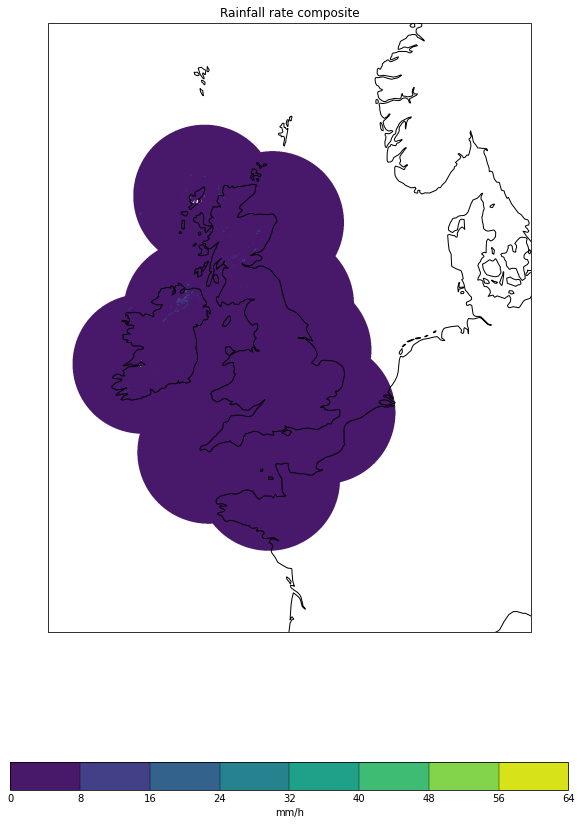

In [14]:
fig1 = matplotlib.pyplot.figure(figsize=(10,16))
iris.quickplot.contourf(radar_cube[288+ (3*72),:,:], )
fig1.gca().coastlines()

In [25]:
import cartopy
import cartopy.crs

/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


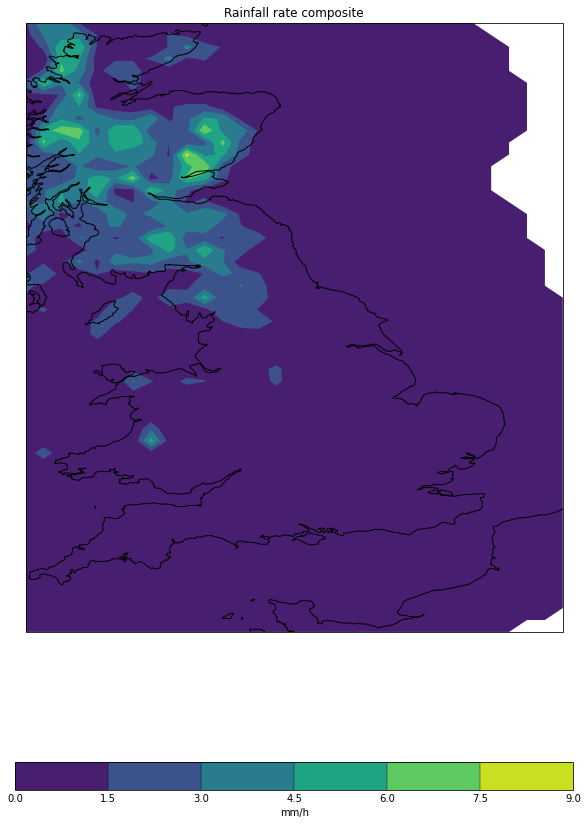

In [51]:
fig1 = matplotlib.pyplot.figure(figsize=(10,16))
iris.quickplot.contourf(radar_cube[288+ (3*72),:,:].regrid(target_grid_cube, iris.analysis.Linear(), ) )
fig1.gca().coastlines()

/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


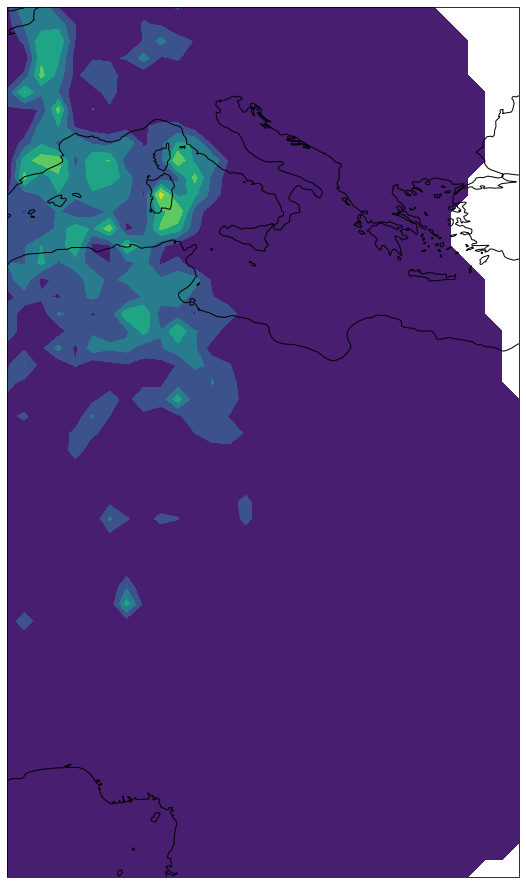

In [ ]:
fig1 = matplotlib.pyplot.figure(figsize=(10,16))
ax1 = fig1.add_subplot(1,1,1, projection=cartopy.crs.PlateCarree())
ax1.contourf()
iris.quickplot.contourf(radar_cube[288+ (3*72),:,:].regrid(target_grid_cube, iris.analysis.Linear(), ) )
fig1.gca().coastlines()

/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


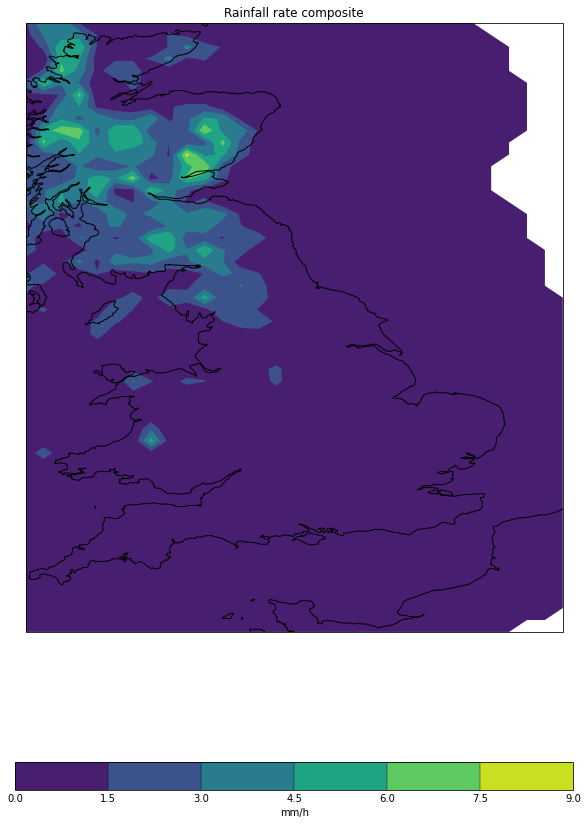

In [32]:
fig1 = matplotlib.pyplot.figure(figsize=(10,16))
# ax1 = fig1.add_subplot(1,1,1, projection=cartopy.crs.TransverseMercator())
iris.quickplot.contourf(radar_cube[288+ (3*72),:,:].regrid(target_grid_cube, iris.analysis.Linear(), ) )
fig1.gca().coastlines()


In [16]:
# add some additional time coord info for subsequent processing
iris.coord_categorisation.add_hour(radar_cube, coord='time')
iris.coord_categorisation.add_day_of_year(radar_cube, coord='time')


In [17]:
# load a simple cube representing the target grid
target_grid_cube = iris.load_cube(
        str(target_cube_path)
    )


In [18]:
coord_3hr = iris.coords.AuxCoord(radar_cube.coord('hour').points // 3,
                                long_name='3hr',
                                 units='hour',
                                )
radar_cube.add_aux_coord(coord_3hr, data_dims=0)
radar_agg_3hr = radar_cube.aggregated_by(['3hr', 'day_of_year'],iris.analysis.SUM)
aux_coord1 = iris.coords.AuxCoord(
    [c1.bound[0] + datetime.timedelta(hours=3) for c1 in radar_agg_3hr.coord('time').cells()],
    long_name='model_accum_time',
    units='mm/h'
)
radar_agg_3hr.add_aux_coord(
    aux_coord1,
    data_dims=0)

# Since we are using ionstantaneous values, which represent an hourly
# rate, we have to divide by 12 to convert to 1 5 minute rate, which
# we can then sum to get to our desired accumulation
radar_agg_3hr.data = radar_agg_3hr.data * (1.0 / 12.0)

In [146]:
# radar_cube.remove_coord('latitude')
# radar_cube.remove_coord('longitude')
# radar_agg_3hr.remove_coord('latitude')
# radar_agg_3hr.remove_coord('longitude')

In [147]:
lat_vals, lon_vals = calc_lat_lon_coords([radar_cube, radar_agg_3hr], 
                                         target_grid_cube)




Calculating index mapping for target grid


/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


In [148]:
# remove these coordinates as they interfere with subsequent calculations
for coord_name in ['model_accum_time', 'forecast_reference_time', 'hour', 'day_of_year','3hr']:
    radar_agg_3hr.remove_coord(coord_name)



CoordinateNotFoundError: 'Expected to find exactly 1 model_accum_time coordinate, but found none.'

In [33]:
import mpl_toolkits.axes_grid1

In [151]:
regridded_cube1 = radar_cube[288,:,:].regrid(target_grid_cube, iris.analysis.Linear(), )

/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


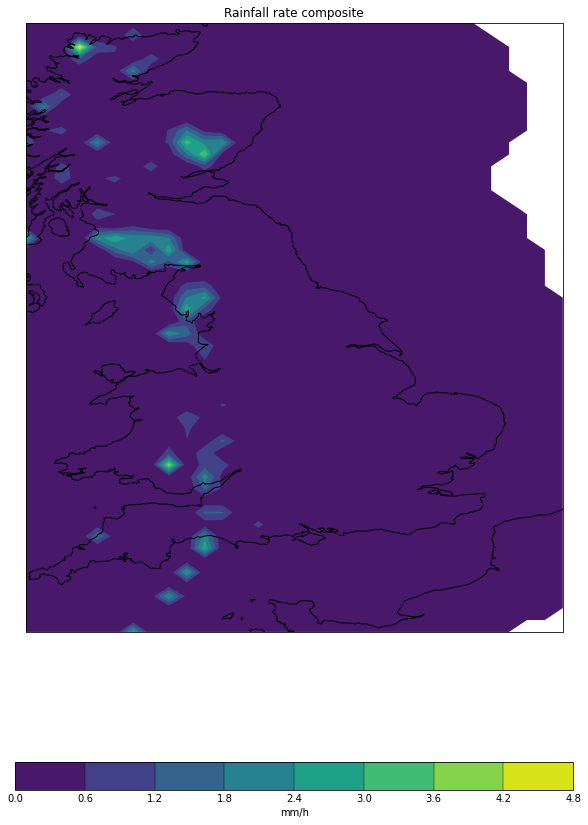

In [152]:
f1 = matplotlib.pyplot.figure(figsize=(10,16))
ax2 = f1.add_subplot(1,1,1,projection=cartopy.crs.PlateCarree())
iris.quickplot.contourf(regridded_cube1, axes=ax2)
ax2.coastlines()

In [95]:
radar_cube.coord('longitude').points.shape

(2175, 1725)

In [98]:
radar_cube

Rainfall Rate Composite (mm/h),time,projection_y_coordinate,projection_x_coordinate
Shape,1152,2175,1725
Dimension coordinates,,,
time,x,-,-
projection_y_coordinate,-,x,-
projection_x_coordinate,-,-,x
Auxiliary coordinates,,,
3hr,x,-,-
day_of_year,x,-,-
forecast_reference_time,x,-,-
hour,x,-,-


In [153]:
X_radar,Y_radar = numpy.meshgrid(radar_cube.coord('projection_x_coordinate').points, radar_cube.coord('projection_y_coordinate').points,)

In [154]:
target_grid_cube.coord_system().as_cartopy_crs().transform_points(
            radar_cube.coord_system().as_cartopy_crs(),
            X_radar,
            Y_radar,
        )[:,:,0]


/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


array([[-12.00641609, -11.99416489, -11.981913  , ...,   9.38620764,
          9.39837587,   9.41054334],
       [-12.0079137 , -11.99566074, -11.98340709, ...,   9.38790146,
          9.40007142,   9.4122406 ],
       [-12.00941199, -11.99715727, -11.98490186, ...,   9.38959606,
          9.40176773,   9.41393862],
       ...,
       [-17.95241506, -17.93349487, -17.91457148, ...,  16.06905922,
         16.0875958 ,  16.10612885],
       [-17.95723089, -17.93830559, -17.91937709, ...,  16.07443258,
         16.09297391,  16.11151171],
       [-17.96204992, -17.94311951, -17.9241859 , ...,  16.07980944,
         16.09835553,  16.11689809]])

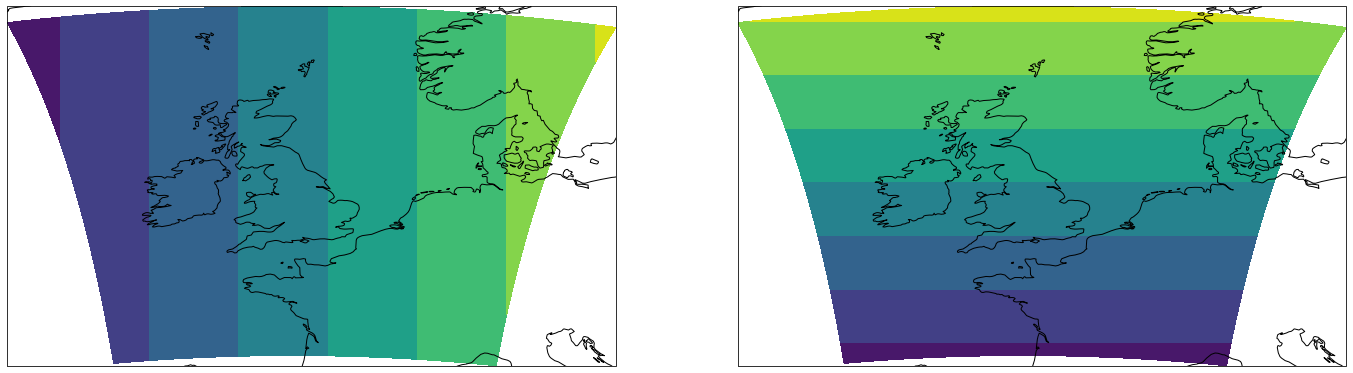

In [155]:
fig1 = matplotlib.pyplot.figure(figsize=(24,24))
ax1 = fig1.add_subplot(1,2,1, projection=cartopy.crs.PlateCarree())
ax1.contourf(X_radar,
             Y_radar,
             radar_cube.coord('longitude').points,
             transform=radar_cube.coord_system().as_cartopy_crs(),
            )
ax1.coastlines()
ax1 = fig1.add_subplot(1,2,2, projection=cartopy.crs.PlateCarree())
ax1.contourf(X_radar,
             Y_radar,
             radar_cube.coord('latitude').points,
             transform=radar_cube.coord_system().as_cartopy_crs(),
            )
ax1.coastlines()

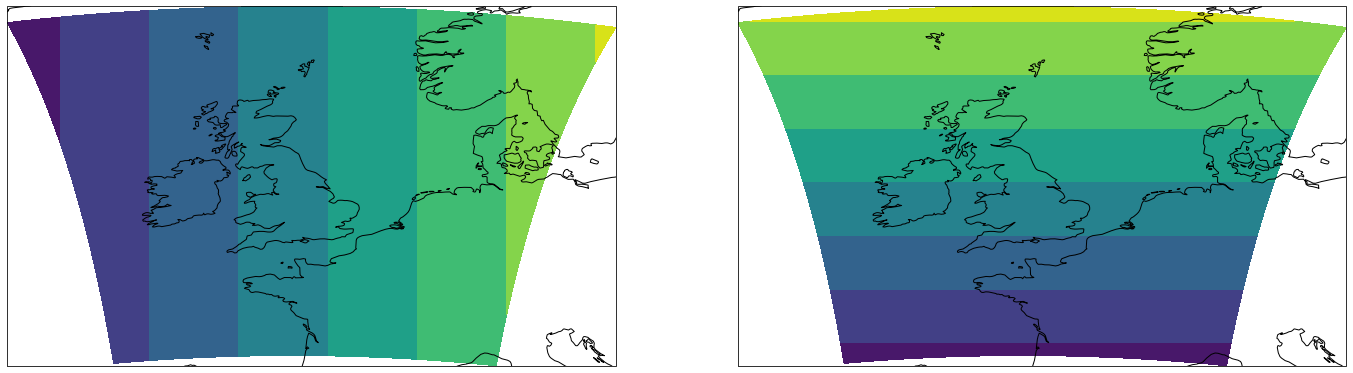

In [137]:
fig1 = matplotlib.pyplot.figure(figsize=(24,24))
ax1 = fig1.add_subplot(1,2,1, projection=cartopy.crs.PlateCarree())
ax1.contourf(X_radar,
             Y_radar,
             target_grid_cube.coord_system().as_cartopy_crs().transform_points(
                 radar_cube.coord_system().as_cartopy_crs(),
                 X_radar,
                 Y_radar,
             )[:,:,0],
             transform=radar_cube.coord_system().as_cartopy_crs(),
            )
ax1.coastlines()
ax1 = fig1.add_subplot(1,2,2, projection=cartopy.crs.PlateCarree())
ax1.contourf(X_radar,
             Y_radar,
             target_grid_cube.coord_system().as_cartopy_crs().transform_points(
                 radar_cube.coord_system().as_cartopy_crs(),
                 X_radar,
                 Y_radar,
             )[:,:,1],
             transform=radar_cube.coord_system().as_cartopy_crs(),
            )
ax1.coastlines()

In [111]:
radar_cube.shape

(1152, 2175, 1725)

In [112]:
radar_cube.coord('longitude').shape

(2175, 1725)

/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


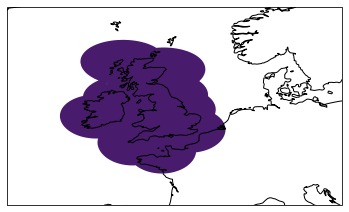

In [110]:
ax1 = matplotlib.pyplot.axes(projection=cartopy.crs.PlateCarree())
iris.plot.contourf(radar_cube[288,:,:], axes=ax1)

ax1.coastlines()

/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


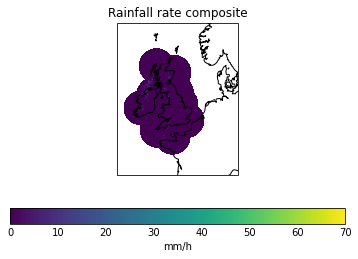

In [103]:
iris.quickplot.pcolormesh(radar_cube[288,:,:])
matplotlib.pyplot.gca().coastlines()

In [157]:
lat_target_index, lon_target_index, num_cells = calc_target_cube_indices(
    lat_vals=lat_vals,
    lon_vals=lon_vals,
    radar_cube=radar_cube,
    target_grid_cube=target_grid_cube,
)

/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


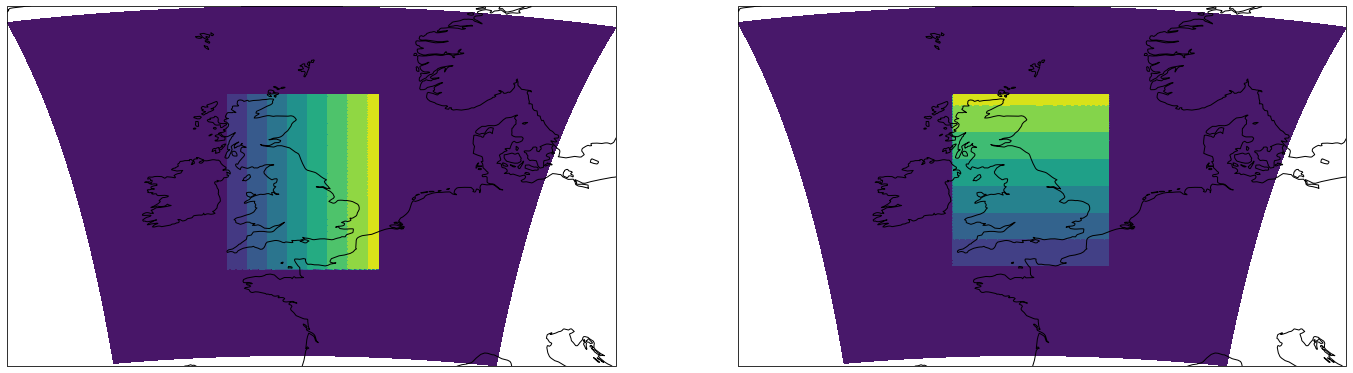

In [159]:
fig1 = matplotlib.pyplot.figure(figsize=(24,24))
ax1 = fig1.add_subplot(1,2,1, projection=cartopy.crs.PlateCarree())
ax1.contourf(X_radar,
             Y_radar,
             lon_target_index,
             transform=radar_cube.coord_system().as_cartopy_crs(),
            )
ax1.coastlines()
ax1 = fig1.add_subplot(1,2,2, projection=cartopy.crs.PlateCarree())
ax1.contourf(X_radar,
             Y_radar,
             lat_target_index,
             transform=radar_cube.coord_system().as_cartopy_crs(),
            )
ax1.coastlines()

In [158]:
# Set up arrays to store regridded radAR precip data
out_vars_dict = {'radar_fraction_in_band_aggregate_3hr': 'VECTOR',
                 'radar_fraction_in_band_instant': 'VECTOR',
                 'bands_mask': 'MASK_VECTOR',
                 'scalar_value_mask': 'MASK_SCALAR',
                 'radar_max_rain_aggregate_3hr': 'SCALAR',
                 'radar_mean_rain_aggregate_3hr': 'SCALAR',
                 'radar_max_rain_instant': 'SCALAR',
                 'radar_mean_rain_instant': 'SCALAR',
                 'fraction_sum_agg': 'SCALAR',
                 'fraction_sum_instant': 'SCALAR',
                 }


out_vars_long_names = {
    'radar_fraction_in_band_aggregate_3hr': 'Fraction radar rainfall cells in specified 3hr aggregate rain band ',
    'radar_fraction_in_band_instant': 'Fraction radar rainfall cells in specified instant rain band',
    'radar_max_rain_aggregate_3hr': 'maximum rain in radar cells within mogreps-g cell',
    'radar_mean_rain_aggregate_3hr': 'average rain in radar cells within mogreps-g cell',
    'radar_max_rain_instant': 'maximum rain in radar cells within mogreps-g cell',
    'radar_mean_rain_instant': 'average rain in radar cells within mogreps-g cell',
    'fraction_sum_agg': 'Sum of fractions for each cell for aggregate 3hr data',
    'fraction_sum_instant': 'Sum of fractions for each cell for instant precip data',
}


In [162]:
regridded_arrays_dict = {}
for var_name in [k1 for k1,v1 in out_vars_dict.items() if v1 == 'VECTOR']:
    regridded_arrays_dict[var_name] = numpy.zeros(
        [len(validity_times),
         target_grid_cube.shape[0],
         target_grid_cube.shape[1],
         len(rainfall_thresholds)])

for var_name in [k1 for k1,v1 in out_vars_dict.items() if v1 == 'MASK_SCALAR']:
    regridded_arrays_dict[var_name] = numpy.ones(
        [len(validity_times), target_grid_cube.shape[0],
         target_grid_cube.shape[1]],
        dtype='bool',
    )

for var_name in [k1 for k1,v1 in out_vars_dict.items() if v1 == 'MASK_VECTOR']:
    regridded_arrays_dict[var_name] = numpy.ones(
        [len(validity_times),
         target_grid_cube.shape[0],
         target_grid_cube.shape[1],
         len(rainfall_thresholds)]
    )

for var_name in [k1 for k1,v1 in out_vars_dict.items() if v1 == 'SCALAR']:
    regridded_arrays_dict[var_name] = numpy.zeros(
        [len(validity_times),
         target_grid_cube.shape[0],
         target_grid_cube.shape[1]]
    )


In [168]:
# iterate through each time, rain amount band, latitude and longitude
for i_time, validity_time in enumerate(validity_times[:1]):
    print(f'Processing radar data for validity time {validity_time}')
    radar_select_time = radar_agg_3hr.extract(iris.Constraint(
        time=lambda c1: compare_time(c1.bound[0], validity_time)))
    masked_radar = numpy.ma.MaskedArray(
        radar_select_time.data.data,
        radar_agg_3hr[0].data.mask)

    radar_instant_select_time = radar_cube.extract(iris.Constraint(
        time=lambda c1: compare_time(c1.point, validity_time)))
    masked_radar_instant = numpy.ma.MaskedArray(
        radar_instant_select_time.data.data,
        radar_cube[0].data.mask)
    for i_lat in range(target_grid_cube.shape[0]):
        for i_lon in range(target_grid_cube.shape[1]):
            selected_cells = (~(radar_select_time.data.mask)) & \
                             (lat_target_index == i_lat) & (
                                         lon_target_index == i_lon)
            masked_radar.mask = ~selected_cells
            masked_radar_instant.mask = ~selected_cells

            radar_cells_in_mg = numpy.count_nonzero(selected_cells)
            # only proceed with processing for this tagret grid cell
            # if there are some radar grid cells within this target
            # grid cell
            if radar_cells_in_mg > 0:
                # set the values for this location to be unmasker,
                # as we have valid radar values for this location
                regridded_arrays_dict['bands_mask'][i_time, i_lat, i_lon, :] = False
                regridded_arrays_dict['scalar_value_mask'][i_time, i_lat, i_lon] = False
                for imp_ix, (imp_key, imp_bounds) in enumerate(
                        rainfall_thresholds.items()):
                    # calculate fraction in band for 3 horaggregate data
                    num_in_band_agg = numpy.count_nonzero(
                        (masked_radar.compressed() >= imp_bounds[0]) &
                        (masked_radar.compressed() <= imp_bounds[1]) )
                    regridded_arrays_dict['radar_fraction_in_band_aggregate_3hr'][
                        i_time, i_lat, i_lon, imp_ix] = num_in_band_agg / (len(masked_radar.compressed()))

                    # calculate raction in band for instant radar data
                    num_in_band_instant = numpy.count_nonzero(
                        (masked_radar_instant.compressed() >= imp_bounds[0]) &
                        (masked_radar_instant.compressed() <= imp_bounds[1]) )
                    regridded_arrays_dict['radar_fraction_in_band_instant'][i_time, i_lat, i_lon, imp_ix] = num_in_band_instant / (len(masked_radar_instant.compressed()))
                regridded_arrays_dict['fraction_sum_agg'][i_time, i_lat, i_lon] = regridded_arrays_dict['radar_fraction_in_band_aggregate_3hr'][i_time, i_lat, i_lon, :].sum()
                regridded_arrays_dict['fraction_sum_instant'][i_time, i_lat, i_lon] = regridded_arrays_dict['radar_fraction_in_band_instant'][i_time, i_lat, i_lon, :].sum()

                # calculate the max and average of all radar cells within each mogreps-g cell
                regridded_arrays_dict['radar_max_rain_aggregate_3hr'][i_time, i_lat, i_lon] = masked_radar.max()
                regridded_arrays_dict['radar_mean_rain_aggregate_3hr'][i_time, i_lat, i_lon] = (masked_radar.sum()) / radar_cells_in_mg

                # create instant radar rate feature data
                regridded_arrays_dict['radar_max_rain_instant'][i_time, i_lat, i_lon] = masked_radar_instant.max()
                regridded_arrays_dict['radar_mean_rain_instant'][i_time, i_lat, i_lon] = (masked_radar_instant.sum()) / radar_cells_in_mg
            else:
                print(f'no radar cells to include at ({i_lat},{i_lon})')

Processing radar data for validity time 2020-02-07 18:00:00
0, 0
0, 1
0, 2
0, 3
0, 4
0, 5
0, 6
0, 7
0, 8
0, 9
0, 10
0, 11
0, 12
0, 13
0, 14
0, 15
0, 16
0, 17
0, 18
0, 19
0, 20
0, 21
0, 22
0, 23
0, 24
0, 25
0, 26
0, 27
0, 28
0, 29
0, 30
no radar cells to include at (0,30)
1, 0
1, 1
1, 2
1, 3
1, 4
1, 5
1, 6
1, 7
1, 8
1, 9
1, 10
1, 11
1, 12
1, 13
1, 14
1, 15
1, 16
1, 17
1, 18
1, 19
1, 20
1, 21
1, 22
1, 23
1, 24
1, 25
1, 26
1, 27
1, 28
1, 29
1, 30
2, 0
2, 1
2, 2
2, 3
2, 4
2, 5
2, 6
2, 7
2, 8
2, 9
2, 10
2, 11
2, 12
2, 13
2, 14
2, 15
2, 16
2, 17
2, 18
2, 19
2, 20
2, 21
2, 22
2, 23
2, 24
2, 25
2, 26
2, 27
2, 28
2, 29
2, 30
3, 0
3, 1
3, 2
3, 3
3, 4
3, 5
3, 6
3, 7
3, 8
3, 9
3, 10
3, 11
3, 12
3, 13
3, 14
3, 15
3, 16
3, 17
3, 18
3, 19
3, 20
3, 21
3, 22
3, 23
3, 24
3, 25
3, 26
3, 27
3, 28
3, 29
3, 30
4, 0
4, 1
4, 2
4, 3
4, 4
4, 5
4, 6
4, 7
4, 8
4, 9
4, 10
4, 11
4, 12
4, 13
4, 14
4, 15
4, 16
4, 17
4, 18
4, 19
4, 20
4, 21
4, 22
4, 23
4, 24
4, 25
4, 26
4, 27
4, 28
4, 29
4, 30
5, 0
5, 1
5, 2
5, 3
5, 4

In [179]:
regridded2 = radar_cube[216,:,:].regrid(target_grid_cube, iris.analysis.Linear())
regridded2

/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


<iris 'Cube' of Rainfall rate Composite / (mm/h) (latitude: 52; longitude: 31)>

In [174]:
validity_times[0]

datetime.datetime(2020, 2, 7, 18, 0)

In [178]:
[c1 for c1 in radar_cube.coord('time').cells()][216]

Cell(point=cftime.DatetimeGregorian(2020, 2, 7, 18, 0, 0, 0, has_year_zero=False), bound=None)

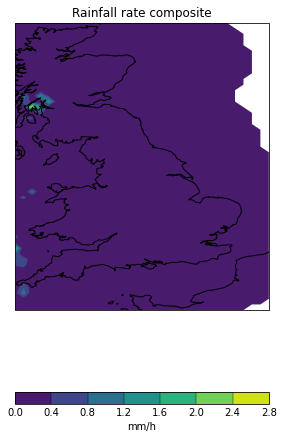

In [182]:
fig1 = matplotlib.pyplot.figure(figsize=(10,10))
ax1 = fig1.add_subplot(1,2,1, projection=cartopy.crs.PlateCarree())
iris.quickplot.contourf(regridded2, axes=ax1)
ax1.coastlines()

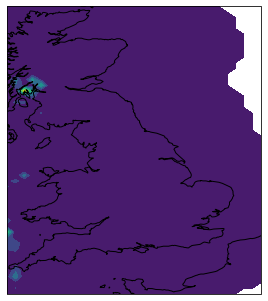

In [181]:
fig1 = matplotlib.pyplot.figure(figsize=(10,10))
ax1 = fig1.add_subplot(1,2,1, projection=cartopy.crs.PlateCarree())
ax1.contourf(X,
             Y,
             regridded2.data,
            )
ax1.coastlines()

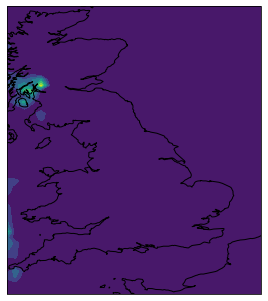

In [184]:
fig1 = matplotlib.pyplot.figure(figsize=(10,10))
ax1 = fig1.add_subplot(1,2,1, projection=cartopy.crs.PlateCarree())
ax1.contourf(X,
             Y,
             regridded_arrays_dict['radar_mean_rain_instant'][0,:,:],
            )
ax1.coastlines()

In [171]:
list(regridded_arrays_dict.keys())

['radar_fraction_in_band_aggregate_3hr',
 'radar_fraction_in_band_instant',
 'scalar_value_mask',
 'bands_mask',
 'radar_max_rain_aggregate_3hr',
 'radar_mean_rain_aggregate_3hr',
 'radar_max_rain_instant',
 'radar_mean_rain_instant',
 'fraction_sum_agg',
 'fraction_sum_instant']

array([[[0.02840245, 0.01087909, 0.04939988, ..., 0.        ,
         0.        , 0.        ],
        [0.10416667, 0.09882353, 0.01408451, ..., 0.        ,
         0.        , 0.        ],
        [0.07198529, 0.21062352, 0.00183392, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.00146628, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [21]:
total_num_pts = (regridded_arrays_dict['fraction_sum_instant'].shape[0] *
                 regridded_arrays_dict['fraction_sum_instant'].shape[1] *
                 regridded_arrays_dict['fraction_sum_instant'].shape[2])


NameError: name 'regridded_arrays_dict' is not defined

In [ ]:
target_lat_coord = self._target_grid_cube.coord('latitude')
target_lon_coord = self._target_grid_cube.coord('longitude')
band_coord = iris.coords.DimCoord(
    [float(b1) for b1 in rainfall_thresholds.keys()],
    bounds=list(rainfall_thresholds.values()),
    var_name='band',
    units='mm',
)
radar_time_coord = iris.coords.DimCoord(
    [vt.timestamp() for vt in
     validity_times],
    var_name='time',
    units=radar_cube.coord('time').units,
)

In [22]:
radar_regrided_cubes = {}

In [ ]:
for var_name in [k1 for k1, v1 in out_vars_dict.items() if v1 == 'VECTOR']:
    radar_regrided_cubes[var_name] = iris.cube.Cube(
        data=numpy.ma.MaskedArray(data=regridded_arrays_dict[var_name],
                                  mask=regridded_arrays_dict['bands_mask'],
                                  ),
        dim_coords_and_dims=(
            (radar_time_coord, 0), (target_lat_coord, 1),
            (target_lon_coord, 2),
            (band_coord, 3)),
        units=None,
        var_name=var_name,
        long_name=out_vars_long_names[var_name],
    )

In [ ]:
num_cells_cube = iris.cube.Cube(
    data=num_cells,
    dim_coords_and_dims=(
     (target_lat_coord, 0), (target_lon_coord, 1),),
    var_name='num_radar_cells',
)

for var_name in [k1 for k1, v1 in out_vars_dict.items()
                 if v1 == 'SCALAR']:
    radar_regrided_cubes[var_name] = iris.cube.Cube(
        data=numpy.ma.MaskedArray(data=regridded_arrays_dict[var_name],
                                  mask=regridded_arrays_dict[
                                      'scalar_value_mask'],
                                  ),
        dim_coords_and_dims=(
            (radar_time_coord, 0), (target_lat_coord, 1),
            (target_lon_coord, 2),),
        units='mm',
        var_name=var_name,
        long_name=out_vars_long_names[var_name],
    )